# Documentação do Projeto de Previsão de Preços de Imóveis

Este notebook documenta as etapas realizadas para construir um modelo de regressão linear para prever os preços de imóveis utilizando o Ames Housing Dataset.

## 1. Carregamento e Exploração Inicial dos Dados

Primeiro, o dataset é baixado usando o KaggleHub e carregado em um DataFrame pandas para exploração inicial.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ames-housing-dataset' dataset.
Path to dataset files: /kaggle/input/ames-housing-dataset


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# O carregamento e a exploração inicial já foram feitos nas células acima.
# As células a seguir mostram o path do dataset e as primeiras linhas do DataFrame.

In [ ]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/shashanknecrothapa/ames-housing-dataset/versions/1/AmesHousing.csv")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## 2. Tratamento de Valores Nulos

Identificamos as colunas com valores nulos. Para este dataset, muitos nulos indicam a ausência de uma característica (ex: 'Alley' nulo significa que não há acesso por beco).

- Para colunas numéricas com nulos (exceto 'Garage Yr Blt'), preenchemos com 0.
- Para 'Garage Yr Blt', preenchemos com o ano de construção da casa ('Year Built').
- Para colunas categóricas com nulos, preenchemos com uma string indicando a ausência da característica (ex: 'NoAlley').
- Para a coluna 'Electrical', preenchemos com o valor mais frequente (moda).

Após o tratamento, verificamos que não há mais valores nulos.

In [ ]:
# Nulos deste dataset nao representam erros, mas sim que a casa não tem alguma
# característica, ex: Alley significa acesso por beco/vielas, os nulos significam que nao tem acesso

colunas_com_nulos = df.columns[df.isnull().sum() > 0]
df_nulos = df[colunas_com_nulos]
df_nulos

,Lot Frontage,Alley,Mas Vnr Type,Mas Vnr Area,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,...,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Pool QC,Fence,Misc Feature
0,141.0,NaN,Stone,112.0,TA,Gd,Gd,BLQ,639.0,Unf,...,Attchd,1960.0,Fin,2.0,528.0,TA,TA,NaN,NaN,NaN
1,80.0,NaN,NaN,0.0,TA,TA,No,Rec,468.0,LwQ,...,Attchd,1961.0,Unf,1.0,730.0,TA,TA,NaN,MnPrv,NaN
2,81.0,NaN,BrkFace,108.0,TA,TA,No,ALQ,923.0,Unf,...,Attchd,1958.0,Unf,1.0,312.0,TA,TA,NaN,NaN,Gar2
3,93.0,NaN,NaN,0.0,TA,TA,No,ALQ,1065.0,Unf,...,Attchd,1968.0,Fin,2.0,522.0,TA,TA,NaN,NaN,NaN
4,74.0,NaN,NaN,0.0,Gd,TA,No,GLQ,791.0,Unf,...,Attchd,1997.0,Fin,2.0,482.0,TA,TA,NaN,MnPrv,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,37.0,NaN,NaN,0.0,TA,TA,Av,GLQ,819.0,Unf,...,Detchd,1984.0,Unf,2.0,588.0,TA,TA,NaN,GdPrv,NaN
2926,NaN,NaN,NaN,0.0,Gd,TA,Av,BLQ,301.0,ALQ,...,Attchd,1983.0,Unf,2.0,484.0,TA,TA,NaN,MnPrv,NaN
2927,62.0,NaN,NaN,0.0,Gd,TA,Av,GLQ,337.0,Unf,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,MnPrv,Shed
2928,77.0,NaN,NaN,0.0,Gd,TA,Av,ALQ,1071.0,LwQ,...,Attchd,1975.0,RFn,2.0,418.0,TA,TA,NaN,NaN,NaN


In [ ]:
nulos_numericos = df_nulos.select_dtypes(include='number').columns
nulos_numericos = list(nulos_numericos)
nulos_numericos.remove('Garage Yr Blt')
df[nulos_numericos] = df[nulos_numericos].fillna(0)

In [ ]:
# O tratamento de nulos já foi feito nas células acima.
# As células a seguir mostram as colunas com nulos antes e depois do tratamento.

In [ ]:
colunas_com_nulos = df.columns[df.isnull().sum() > 0]
df_nulos = df[colunas_com_nulos]
df_nulos

,Alley,Mas Vnr Type,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Electrical,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Qual,Garage Cond,Pool QC,Fence,Misc Feature
0,NaN,Stone,TA,Gd,Gd,BLQ,Unf,SBrkr,Gd,Attchd,1960.0,Fin,TA,TA,NaN,NaN,NaN
1,NaN,NaN,TA,TA,No,Rec,LwQ,SBrkr,NaN,Attchd,1961.0,Unf,TA,TA,NaN,MnPrv,NaN
2,NaN,BrkFace,TA,TA,No,ALQ,Unf,SBrkr,NaN,Attchd,1958.0,Unf,TA,TA,NaN,NaN,Gar2
3,NaN,NaN,TA,TA,No,ALQ,Unf,SBrkr,TA,Attchd,1968.0,Fin,TA,TA,NaN,NaN,NaN
4,NaN,NaN,Gd,TA,No,GLQ,Unf,SBrkr,TA,Attchd,1997.0,Fin,TA,TA,NaN,MnPrv,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,NaN,NaN,TA,TA,Av,GLQ,Unf,SBrkr,NaN,Detchd,1984.0,Unf,TA,TA,NaN,GdPrv,NaN
2926,NaN,NaN,Gd,TA,Av,BLQ,ALQ,SBrkr,NaN,Attchd,1983.0,Unf,TA,TA,NaN,MnPrv,NaN
2927,NaN,NaN,Gd,TA,Av,GLQ,Unf,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MnPrv,Shed
2928,NaN,NaN,Gd,TA,Av,ALQ,LwQ,SBrkr,TA,Attchd,1975.0,RFn,TA,TA,NaN,NaN,NaN


In [ ]:
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(df['Year Built'])

In [ ]:
colunas_com_nulos = df.columns[df.isnull().sum() > 0]
df_nulos = df[colunas_com_nulos]
df_nulos

,Alley,Mas Vnr Type,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Electrical,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Pool QC,Fence,Misc Feature
0,NaN,Stone,TA,Gd,Gd,BLQ,Unf,SBrkr,Gd,Attchd,Fin,TA,TA,NaN,NaN,NaN
1,NaN,NaN,TA,TA,No,Rec,LwQ,SBrkr,NaN,Attchd,Unf,TA,TA,NaN,MnPrv,NaN
2,NaN,BrkFace,TA,TA,No,ALQ,Unf,SBrkr,NaN,Attchd,Unf,TA,TA,NaN,NaN,Gar2
3,NaN,NaN,TA,TA,No,ALQ,Unf,SBrkr,TA,Attchd,Fin,TA,TA,NaN,NaN,NaN
4,NaN,NaN,Gd,TA,No,GLQ,Unf,SBrkr,TA,Attchd,Fin,TA,TA,NaN,MnPrv,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,NaN,NaN,TA,TA,Av,GLQ,Unf,SBrkr,NaN,Detchd,Unf,TA,TA,NaN,GdPrv,NaN
2926,NaN,NaN,Gd,TA,Av,BLQ,ALQ,SBrkr,NaN,Attchd,Unf,TA,TA,NaN,MnPrv,NaN
2927,NaN,NaN,Gd,TA,Av,GLQ,Unf,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,MnPrv,Shed
2928,NaN,NaN,Gd,TA,Av,ALQ,LwQ,SBrkr,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN


In [ ]:
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

In [ ]:
colunas_com_nulos = df.columns[df.isnull().sum() > 0]
df_nulos = df[colunas_com_nulos]
df_nulos

,Alley,Mas Vnr Type,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Pool QC,Fence,Misc Feature
0,NaN,Stone,TA,Gd,Gd,BLQ,Unf,Gd,Attchd,Fin,TA,TA,NaN,NaN,NaN
1,NaN,NaN,TA,TA,No,Rec,LwQ,NaN,Attchd,Unf,TA,TA,NaN,MnPrv,NaN
2,NaN,BrkFace,TA,TA,No,ALQ,Unf,NaN,Attchd,Unf,TA,TA,NaN,NaN,Gar2
3,NaN,NaN,TA,TA,No,ALQ,Unf,TA,Attchd,Fin,TA,TA,NaN,NaN,NaN
4,NaN,NaN,Gd,TA,No,GLQ,Unf,TA,Attchd,Fin,TA,TA,NaN,MnPrv,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,NaN,NaN,TA,TA,Av,GLQ,Unf,NaN,Detchd,Unf,TA,TA,NaN,GdPrv,NaN
2926,NaN,NaN,Gd,TA,Av,BLQ,ALQ,NaN,Attchd,Unf,TA,TA,NaN,MnPrv,NaN
2927,NaN,NaN,Gd,TA,Av,GLQ,Unf,NaN,NaN,NaN,NaN,NaN,NaN,MnPrv,Shed
2928,NaN,NaN,Gd,TA,Av,ALQ,LwQ,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN


In [ ]:
lista_valores_nulos = df_nulos.columns.to_list()
for col in lista_valores_nulos:
  df[col] = df[col].fillna(f'No{col}')

In [ ]:
colunas_com_nulos = df.columns[df.isnull().sum() > 0]
df_nulos = df[colunas_com_nulos]
df_nulos

""
0
1
2
3
4
...
2925
2926
2927
2928


## 3. Seleção de Features com LassoCV

Para reduzir a dimensionalidade e selecionar as features mais relevantes, utilizamos o modelo Lasso com validação cruzada (LassoCV).

- Separamos as features (X) e o target (y - 'SalePrice').
- Identificamos colunas categóricas e numéricas.
- Criamos variáveis dummy para as colunas categóricas.
- Combinamos as colunas numéricas e as dummies.
- Convertemos colunas booleanas resultantes de dummy para inteiros.
- Escalamos as features, pois o Lasso é sensível à escala.
- Aplicamos o LassoCV para encontrar as features com coeficientes diferentes de zero.
- Criamos um novo DataFrame X_final contendo apenas as features selecionadas.

In [ ]:
# Separar features e target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Separar colunas categóricas e numéricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Dummyzar apenas categóricas
X_dummies = pd.get_dummies(X[cat_cols], drop_first=True)

# Combinar com colunas numéricas
X_final = pd.concat([X[num_cols], X_dummies], axis=1)

# Transformar bools em int
bool_cols = X_final.select_dtypes(include=['bool']).columns
X_final[bool_cols] = X_final[bool_cols].astype(int)

# Escalar features (Lasso sensível à escala)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

In [ ]:
# A seleção de features com LassoCV já foi feita nas células acima.
# As células a seguir mostram as features selecionadas e seus coeficientes.

In [ ]:
# LassoCV encontra o melhor alpha automaticamente
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

In [ ]:
# Criar um dataframe com as variáveis e seus coeficientes
coef_df = pd.DataFrame({
    'Feature': X_final.columns,
    'Coeficiente': lasso.coef_
})

# Mostrar apenas as variáveis selecionadas (coef != 0)
selected_features_df = coef_df[coef_df['Coeficiente'] != 0].sort_values(by='Coeficiente', ascending=False)
print(selected_features_df)

# Extrair lista de nomes das colunas selecionadas
selected_features = selected_features_df['Feature'].tolist()

# Criar X_final apenas com essas features
X_final = X_final[selected_features]


                  Feature   Coeficiente
17            Gr Liv Area  24057.315730
5            Overall Qual  14117.893375
79   Neighborhood_NridgHt   8267.195603
7              Year Built   7888.356084
85   Neighborhood_StoneBr   5827.908768
..                    ...           ...
174          Bsmt Qual_Gd  -6372.934791
251            Pool QC_Gd  -6454.308368
35               Misc Val  -6709.804509
214       Kitchen Qual_Gd  -8696.048656
216       Kitchen Qual_TA  -9460.447677

[133 rows x 2 columns]


## 4. Treinamento do Modelo de Regressão Linear

Com as features selecionadas, dividimos os dados em conjuntos de treino e teste e treinamos um modelo de Regressão Linear.

In [ ]:
# O treinamento do modelo já foi feito nas células acima.
# A célula a seguir mostra o R² no conjunto de teste.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)
linreg = LinearRegression().fit(X_train, y_train)
r2_test = linreg.score(X_test, y_test)
print("R² no teste:", r2_test)


R² no teste: 0.8867006931308665


## 5. Avaliação do Modelo

Avaliamos o desempenho do modelo nos dados de teste utilizando métricas comuns de regressão:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)

In [ ]:
# A avaliação do modelo já foi feita nas células acima.
# A célula a seguir mostra os valores de MSE, RMSE e MAE.

In [ ]:
y_pred = linreg.predict(X_test)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)


MSE: 796429311.1529514
RMSE: 28221.0791989419
MAE: 16219.844731491432


## 6. Análise de Outliers no Preço de Venda

Analisamos a distribuição da variável target 'SalePrice' e identificamos outliers utilizando o método do Intervalo Interquartil (IQR).

In [ ]:
# A análise de outliers já foi feita nas células acima.
# As células a seguir mostram a descrição estatística e um boxplot de 'SalePrice',
# além da identificação dos outliers mas que não se tratam de erros.
#Após a análise deduzimos que o valor está correto, tratam-se apenas de casas com um valor alto, então mantemos

In [ ]:
df['SalePrice'].describe()

,SalePrice
count,2930.000000
mean,180796.060068
std,79886.692357
min,12789.000000
25%,129500.000000
50%,160000.000000
75%,213500.000000
max,755000.000000


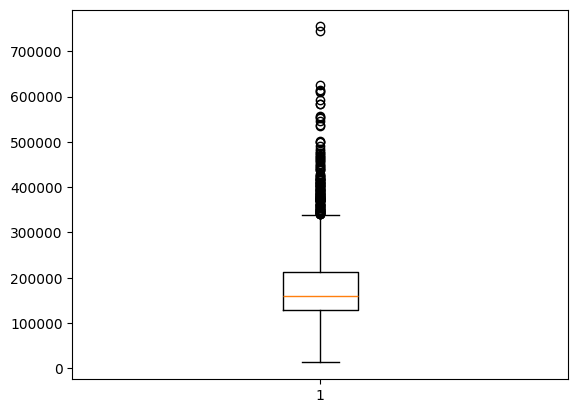

In [ ]:
plt.boxplot(df['SalePrice'])
plt.show()

In [ ]:
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]
display(outliers)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
15,16,527216070,60,RL,47.0,53504,Pave,NoAlley,IR2,HLS,...,0,NoPool QC,NoFence,NoMisc Feature,0,6,2010,WD,Normal,538000
17,18,527258010,20,RL,88.0,11394,Pave,NoAlley,Reg,Lvl,...,0,NoPool QC,NoFence,NoMisc Feature,0,6,2010,New,Partial,394432
36,37,528108120,60,RL,102.0,12858,Pave,NoAlley,IR1,Lvl,...,0,NoPool QC,NoFence,NoMisc Feature,0,1,2010,New,Partial,376162
38,39,528120060,20,RL,83.0,10159,Pave,NoAlley,IR1,Lvl,...,0,NoPool QC,NoFence,NoMisc Feature,0,4,2010,New,Partial,395192
44,45,528150070,20,RL,100.0,12919,Pave,NoAlley,IR1,Lvl,...,0,NoPool QC,NoFence,NoMisc Feature,0,3,2010,New,Partial,611657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,2667,902400110,75,RM,90.0,22950,Pave,NoAlley,IR2,Lvl,...,0,NoPool QC,GdPrv,NoMisc Feature,0,6,2006,WD,Normal,475000
2737,2738,905427030,75,RL,60.0,19800,Pave,NoAlley,Reg,Lvl,...,0,NoPool QC,NoFence,NoMisc Feature,0,12,2006,WD,Normal,415000
2883,2884,911370430,120,RM,41.0,5748,Pave,NoAlley,IR1,HLS,...,0,NoPool QC,NoFence,NoMisc Feature,0,2,2006,New,Partial,375000
2901,2902,921205030,20,RL,88.0,11443,Pave,NoAlley,Reg,Lvl,...,0,NoPool QC,NoFence,NoMisc Feature,0,3,2006,New,Partial,369900


# 7. Conclusão

Foi feito todo o tratamento e treinamento do modelo utilizando regressão linear, pois trata-se apenas de um projeto para fins educacionais. Porém, valores de casas não se tratam de valores lineares, e nem de valores com baixas quantidades de variáveis que este modelo se comporta melhor. Ou seja, por mais que o modelo tenha uma boa quantidade de acertos, as casas com valores mais discrepantes, tem um sério problema para serem previstas. Está sendo criado o mesmo projeto, porém agora utilizando árvores como modelo.